# Titanic Data Analysis

### Import Data

In [1]:
# Import Libraries
import pandas as pd
import pylab as P
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

# Importing Titanic Data
data = pd.read_csv('Data/titanic_full.csv', header=0)

### Exploring Data Statistically

Histogram by Age


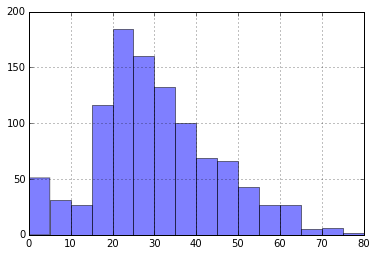

Histogram by Class


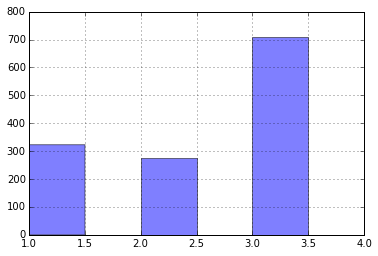

In [14]:
%matplotlib inline
print "Histogram by Age"
data['age'].dropna().hist(bins=16, range=(0,80), alpha = .5)
P.show()
print "Histogram by Class"
data['pclass'].dropna().hist(bins=6, range=(1,4), alpha = .5)
P.show()

### Data Cleaning

In [3]:
# Converting to numbers - Sex, Family Size, and Embarked
data['nSex'] = data['sex'].map({'female':0, 'male':1})
dummies = pd.get_dummies(data['embarked']).astype(float)
data = pd.concat([data, dummies], axis=1)
data['nFamilySize'] = data['sibsp'] + data['parch']

# To Fill in Age according to Sex and Class
median_ages = np.zeros((2,3))
for i in range(0,2):
	for j in range(0,3):
		median_ages[i,j] = data[(data['nSex'] == i) & (data['pclass'] == j+1)]['age'].dropna().median()
data['nAge'] = data['age']
for i in range(0,2):
	for j in range(0,3):
		data.loc[(data.age.isnull()) & (data.nSex == i) & (data.pclass == j+1),'nAge'] = median_ages[i,j]
median_fare = np.zeros((1,3))

# To Fill in Fare according to Class
for i in range(0,1):
	for j in range(0,3):
		median_fare[i,j] = data[(data['pclass'] == j+1) & (data['fare'] != 0)]['age'].median()
data['nFare'] = data['fare']
for i in range(0,1):
	for j in range(0,3):
		data.loc[((data.fare.isnull()) | (data.fare == 0)) & (data.pclass == j+1),'nFare'] = median_fare[i,j]

### Creating Testing Data

In [4]:
#Split up data set (70 Train, 30 Split - sklearn train test split)
train, test = train_test_split( data, test_size=0.3, random_state=42)

traindata = train[['survived','nSex','S', 'C', 'Q','nFamilySize','nAge','nFare','pclass']]
traindata = traindata.values
traindataX = train[['nSex','S', 'C', 'Q','nFamilySize','nAge','nFare','pclass']]
traindataX = traindataX.values
traindataY = train[['survived']]
traindataY = np.ravel(traindataY)

testdataF = pd.DataFrame(test[['nSex','S', 'C', 'Q','nFamilySize','nAge','nFare','pclass']])
testdata = testdataF.values

### Creating Model 1 (Random Forest)

In [5]:
#Split up data set (70 Train, 30 Split - sklearn train test split)
forest = RandomForestClassifier(n_estimators = 1300)
forest = forest.fit(traindata[0::,1::],traindata[0::,0])
forestOutput = pd.DataFrame(forest.predict(testdata))

 ### Creating Model 2 (Logistic Regression)

In [6]:
logisticRegression = LogisticRegression()
logisticRegression = logisticRegression.fit(traindataX,traindataY)
logisticRegressionOutput = pd.DataFrame(logisticRegression.predict(testdata))

### Creating Model 3 (Support Vector Machines)  

In [7]:
supportVC = SVC()
supportVC = supportVC.fit(traindataX,traindataY)
supportVCOutput = pd.DataFrame(supportVC.predict(testdata))

### Model Evaluation

In [8]:
# Saving the True Surviving Data
actual = test[['survived']]

# Tale showing the different evaluations of each Model
model1 = forestOutput[0]
model2 = logisticRegressionOutput[0]
model3 = supportVCOutput[0]
ratioTable = pd.DataFrame({'Random_Forrest': pd.Series([float(0)], index=['Accuracy','F1 Binary','Mean Absolute Error', 'R^2'])})
ratioTable.Random_Forrest[0] = accuracy_score(actual, model1)
ratioTable.Random_Forrest[1] = f1_score(actual, model1, average='binary')
ratioTable.Random_Forrest[2] = mean_absolute_error(actual, model1)
ratioTable.Random_Forrest[3] = r2_score(actual, model1)
ratioTable['Logistic_Regression'] = float(0)
ratioTable.Logistic_Regression[0] = accuracy_score(actual, model2)
ratioTable.Logistic_Regression[1] = f1_score(actual, model2, average='binary')
ratioTable.Logistic_Regression[2] = mean_absolute_error(actual, model2)
ratioTable.Logistic_Regression[3] = r2_score(actual, model2)
ratioTable['Support_Vector_Machines'] = float(0)
ratioTable.Support_Vector_Machines[0] = accuracy_score(actual, model3)
ratioTable.Support_Vector_Machines[1] = f1_score(actual, model3, average='binary')
ratioTable.Support_Vector_Machines[2] = mean_absolute_error(actual, model3)
ratioTable.Support_Vector_Machines[3] = r2_score(actual, model3)

print ratioTable

                     Random_Forrest  Logistic_Regression  \
Accuracy                   0.786260             0.801527   
F1 Binary                  0.735849             0.740000   
Mean Absolute Error        0.213740             0.198473   
R^2                        0.127959             0.190247   

                     Support_Vector_Machines  
Accuracy                            0.661578  
F1 Binary                           0.523297  
Mean Absolute Error                 0.338422  
R^2                                -0.380732  


### Feature Importance for Forrest

Feature ranking:
1. nSex (0.296085)
2. S (0.272061)
3. C (0.234712)
4. Q (0.081391)
5. nFamilySize (0.078954)
6. nAge (0.018360)
7. nFare (0.012727)
8. pclass (0.005710)


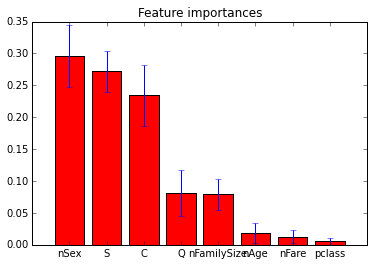

In [15]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(8):
    print("%d. %s (%f)" % (f + 1, testdataF.columns.values[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(8), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(8), testdataF.columns.values)
plt.xlim([-1, 8])
plt.show()

### Confusion Matrix

In [12]:
print 'Random Forest Confusion Matrix'
print confusion_matrix(actual['survived'], forestOutput[0])
print 'Logistic Regression Confusion Matrix'
print confusion_matrix(actual['survived'], logisticRegressionOutput[0])
print 'Support Vector Machines Confusion Matrix'
print confusion_matrix(actual['survived'], supportVCOutput[0])

Random Forest Confusion Matrix
[[192  32]
 [ 52 117]]
Logistic Regression Confusion Matrix
[[204  20]
 [ 58 111]]
Support Vector Machines Confusion Matrix
[[187  37]
 [ 96  73]]


### Print to File

In [ ]:
predictions_file = open("model1.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["Survived"])
open_file_object.writerows(zip(model1output))
predictions_file.close()

predictions_file = open("model2.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["Survived"])
open_file_object.writerows(zip(model2output))
predictions_file.close()

predictions_file = open("model3.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["Survived"])
open_file_object.writerows(zip(model3output))
predictions_file.close()